### Cell 1: Imports and Path Definitions

In [1]:
import json
import re
import ast
import inspect
import importlib.util
from pathlib import Path
from types import ModuleType
from typing import Callable, Any
import pandas as pd
from tqdm.notebook import tqdm
from datasets import load_dataset, Dataset

# --- Path and Directory Definitions ---
def find_project_root(marker: str = ".git") -> Path:
    current_path = Path.cwd().resolve()
    while current_path != current_path.parent:
        if (current_path / marker).exists():
            return current_path
        current_path = current_path.parent
    raise FileNotFoundError(f"Could not find project root. Marker '{marker}' not found.")

PROJECT_ROOT = find_project_root()
DATA_DIR = PROJECT_ROOT / 'data'

# --- INPUT: The directory containing the processed manifests to be validated ---
PROCESSED_MANIFEST_DIR = DATA_DIR / "tier-manifests-gen-processed"

# --- Define the list of models to validate ---
MODELS = ['openai_gpt-4.1', 'google_gemini-2.5-flash']

print(f"Project root: {PROJECT_ROOT}")
print(f"Validation Input Directory: {PROCESSED_MANIFEST_DIR}")

# --- Ensure Input Directory Exists ---
if not PROCESSED_MANIFEST_DIR.is_dir():
    raise FileNotFoundError(f"INPUT DIRECTORY NOT FOUND: {PROCESSED_MANIFEST_DIR}")

Project root: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math
Validation Input Directory: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/tier-manifests-gen-processed


### Cell 2: Data Loaders and Ground Truth Utilities

In [2]:
# --- Load GSM8K Dataset for ground truth answers ---
GSM8K_TRAIN: Dataset = load_dataset("gsm8k", "main")["train"]

# --- Utility functions to load manifest components and ground truth data ---

def load_function_module(tier: str, index: int, model: str) -> ModuleType | None:
    """Dynamically loads the 'solve.py' module for a given manifest."""
    py_file_path = PROCESSED_MANIFEST_DIR / tier / str(index) / f"{model}.py"
    if not py_file_path.exists(): return None
    module_name = f"manifests.val.t{tier}.i{index}.m_{model.replace('.', '_')}"
    spec = importlib.util.spec_from_file_location(module_name, py_file_path)
    if spec and spec.loader:
        module = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(module)
        return module
    return None

def load_logical_steps(tier: str, index: int, model: str) -> list[dict] | None:
    """Loads the 'logical_steps.json' for a given manifest."""
    json_file_path = PROCESSED_MANIFEST_DIR / tier / str(index) / f"{model}.json"
    try:
        return json.loads(json_file_path.read_text(encoding='utf-8'))
    except (FileNotFoundError, json.JSONDecodeError):
        return None

def get_ground_truth_answer(index: int) -> float | None:
    """Extracts the final numeric answer from the GSM8K dataset."""
    try:
        answer_text = GSM8K_TRAIN[int(index)]['answer']
        # The final answer is always after '####'
        final_answer_str = answer_text.split('####')[-1].strip().replace(',', '')
        return float(final_answer_str)
    except (ValueError, IndexError):
        return None

def get_original_solution_lines(index: int) -> dict[str, str] | None:
    """Extracts the original solution into a line-numbered dictionary."""
    try:
        solution_text = GSM8K_TRAIN[int(index)]["answer"]
        lines = [ln.strip() for ln in solution_text.splitlines() if ln.strip()]
        if lines and re.match(r"^####\s*[\d\.,]+$", lines[-1]):
            lines.pop(-1)
        return {f"L{i+1}": line for i, line in enumerate(lines)}
    except IndexError:
        return None

print("Data loading utilities are defined.")

Data loading utilities are defined.


### Cell 3: Core Validation Functions

In [3]:
# --- Helper for consistent number comparison ---
def normalize_value(value):
    if isinstance(value, float) and value.is_integer(): return int(value)
    return value


# --- Validation Function 1: Check Final Answer ---
def check_answer(solve_function: Callable, ground_truth_answer: float) -> dict:
    """
    Executes the solve() function and compares its result against the ground truth.
    
    Returns a dictionary with 'status' ('pass', 'fail', 'error') and details.
    """
    try:
        result = solve_function()
    except Exception as e:
        return {"status": "execution_error", "details": str(e), "computed_answer": None}
    
    # Compare normalized values to handle float/int differences (e.g., 15.0 vs 15)
    norm_result = normalize_value(result)
    norm_truth = normalize_value(ground_truth_answer)
    
    if norm_result == norm_truth:
        return {"status": "pass", "details": None, "computed_answer": result}
    else:
        details = f"Expected {ground_truth_answer}, but got {result}."
        return {"status": "fail", "details": details, "computed_answer": result}


# --- Validation Function 2: Check Template Reconstruction ---
def reconstruct_and_validate_lines(
    logical_steps: list[dict],
    solve_function: Callable,
    original_lines: dict[str, str]
) -> dict:
    """
    Reconstructs solution lines from templates and compares them to the original.
    
    As you noted, this currently uses a strict string match. It can be enhanced later
    with more sophisticated semantic/syntactic comparison.
    """
    # 1. Get the correct variable values by executing the function
    try:
        src = inspect.getsource(solve_function)
        tree = ast.parse(src)
        func_def = tree.body[0]
        local_env = {}
        # Simple execution trace, assuming no Fraction class needed for this step
        for stmt in func_def.body:
            if isinstance(stmt, ast.Assign):
                module_node = ast.Module([stmt], type_ignores=[])
                code_obj = compile(module_node, '<string>', 'exec')
                exec(code_obj, {}, local_env)
        trace = local_env
    except Exception:
        return {"match_score": 0.0, "mismatched_lines": list(original_lines.keys())}

    # 2. Reconstruct lines using templates and the trace
    reconstructed_lines = {}
    for step in logical_steps:
        ln = step["line_number"]
        template = step["solution_line_template"]
        try:
            # Use .format_map() for safe formatting with missing keys
            reconstructed_lines[ln] = template.format_map(trace)
        except (KeyError, ValueError):
            reconstructed_lines[ln] = "FORMATTING_ERROR"

    # 3. Compare and score
    match_count = 0
    mismatched = []
    for ln, original_text in original_lines.items():
        if ln in reconstructed_lines and reconstructed_lines[ln] == original_text:
            match_count += 1
        else:
            mismatched.append(ln)
            
    score = match_count / len(original_lines) if original_lines else 1.0
    return {"match_score": score, "mismatched_lines": mismatched}


print("Core validation functions are defined.")

Core validation functions are defined.


### Cell 4: Validation orchestrator

In [4]:
def validate_manifest(tier: str, index: int, model: str) -> dict | None:
    """
    Runs all validation checks for a single manifest and returns a summary report.
    """
    # 1. Load all necessary components
    solve_module = load_function_module(tier, index, model)
    logical_steps = load_logical_steps(tier, index, model)
    ground_truth_answer = get_ground_truth_answer(index)
    original_lines = get_original_solution_lines(index)
    
    if not all([solve_module, logical_steps, ground_truth_answer, original_lines]):
        return None # Incomplete data, cannot validate

    solve_function = solve_module.solve
    
    # 2. Run the validation checks
    answer_check_result = check_answer(solve_function, ground_truth_answer)
    reconstruction_result = reconstruct_and_validate_lines(logical_steps, solve_function, original_lines)
    
    # 3. Compile the final report
    report = {
        "index": index,
        "tier": tier,
        "model": model,
        "answer_check_status": answer_check_result["status"],
        "reconstruction_score": reconstruction_result["match_score"],
        "computed_answer": answer_check_result["computed_answer"],
        "ground_truth_answer": ground_truth_answer,
        "mismatched_lines": reconstruction_result["mismatched_lines"]
    }
    return report

print("Validation orchestrator is defined.")

Validation orchestrator is defined.


### Cell 5: Main driver and report generation

In [5]:
def run_full_validation_pipeline():
    """
    Iterates through all processed manifests, validates them, and saves a report.
    """
    print("--- Starting Full Manifest Validation ---")
    all_reports = []
    
    tier_dirs = sorted([d for d in PROCESSED_MANIFEST_DIR.iterdir() if d.is_dir() and d.name.startswith('tier')])

    for tier_dir in tqdm(tier_dirs, desc="Validating Tiers"):
        index_dirs = sorted([d for d in tier_dir.iterdir() if d.is_dir() and d.name.isdigit()], key=lambda p: int(p.name))
        
        for index_dir in tqdm(index_dirs, desc=f"Processing {tier_dir.name}", leave=False):
            for model in MODELS:
                report = validate_manifest(tier_dir.name, int(index_dir.name), model)
                if report:
                    all_reports.append(report)

    # --- Save the final validation report ---
    if all_reports:
        report_df = pd.DataFrame(all_reports)
        report_path = PROCESSED_MANIFEST_DIR / "manifest_validation_report.csv"
        report_df.to_csv(report_path, index=False)
        
        print("\n--- Validation Complete ---")
        print(f"Validated {len(report_df)} manifests.")
        print(f"Report saved to: {report_path}")
        
        # Display summary statistics
        print("\n--- Summary Report ---")
        answer_pass_rate = (report_df['answer_check_status'] == 'pass').mean()
        perfect_recon_rate = (report_df['reconstruction_score'] == 1.0).mean()
        
        print(f"Overall Answer Correctness: {answer_pass_rate:.2%}")
        print(f"Perfect Reconstruction Rate: {perfect_recon_rate:.2%}")
        
        print("\nBreakdown by Model:")
        display(report_df.groupby('model')['answer_check_status'].value_counts(normalize=True).unstack(fill_value=0).round(3))
        
    else:
        print("No manifests were found to validate.")
        
# --- Execute the Validation Pipeline ---
run_full_validation_pipeline()

--- Starting Full Manifest Validation ---


Validating Tiers:   0%|          | 0/4 [00:00<?, ?it/s]

Processing tier1:   0%|          | 0/1138 [00:00<?, ?it/s]

Processing tier2:   0%|          | 0/332 [00:00<?, ?it/s]

Processing tier3:   0%|          | 0/1262 [00:00<?, ?it/s]

Processing tier4:   0%|          | 0/185 [00:00<?, ?it/s]


--- Validation Complete ---
Validated 4794 manifests.
Report saved to: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/tier-manifests-gen-processed/manifest_validation_report.csv

--- Summary Report ---
Overall Answer Correctness: 99.10%
Perfect Reconstruction Rate: 41.01%

Breakdown by Model:


answer_check_status,execution_error,fail,pass
model,,,
google_gemini-2.5-flash,0.0,0.006,0.993
openai_gpt-4.1,0.0,0.012,0.988


### Analyze the reconstruction scores

In [6]:
# This cell loads the validation report and analyzes the reconstruction scores.

# --- 1. Define the path to the report ---
REPORT_PATH = PROCESSED_MANIFEST_DIR / "manifest_validation_report.csv"

# --- 2. Load the data and perform the analysis ---
try:
    report_df = pd.read_csv(REPORT_PATH)
    print(f"Successfully loaded report from: {REPORT_PATH}\n")

    # --- 3. Get and display the value counts for the reconstruction score ---
    # We sort by the score itself (the index) for better readability.
    score_counts = report_df['reconstruction_score'].value_counts().sort_index(ascending=False)

    print("--- Reconstruction Score Value Counts ---")
    print("This table shows how many manifests achieved each specific reconstruction score.")
    print("A score of 1.0 indicates a perfect match between original and reconstructed lines.\n")
    print(score_counts)

    # --- 4. Also display the same information as percentages ---
    print("\n" + "-"*40)
    print("\n--- Reconstruction Score Percentages ---")
    score_percentages = report_df['reconstruction_score'].value_counts(normalize=True).sort_index(ascending=False)
    
    # Format the output for clarity
    formatted_percentages = (score_percentages * 100).round(2).astype(str) + '%'
    print(formatted_percentages)

except FileNotFoundError:
    print(f"ERROR: Validation report not found at {REPORT_PATH}")
    print("Please ensure you have run the full validation pipeline in the previous cell first.")

Successfully loaded report from: /Users/arvindsuresh/Documents/Github/Erdos-DL-June25-Math/data/tier-manifests-gen-processed/manifest_validation_report.csv

--- Reconstruction Score Value Counts ---
This table shows how many manifests achieved each specific reconstruction score.
A score of 1.0 indicates a perfect match between original and reconstructed lines.

reconstruction_score
1.000000    1966
0.875000       1
0.857143       6
0.833333      15
0.800000      41
0.750000     128
0.714286       6
0.666667     173
0.625000       1
0.600000      43
0.571429      15
0.500000     362
0.444444       1
0.428571       4
0.400000      59
0.375000       3
0.333333     255
0.285714      10
0.250000     148
0.222222       1
0.200000      88
0.166667      36
0.142857      15
0.125000      10
0.111111       1
0.000000    1406
Name: count, dtype: int64

----------------------------------------

--- Reconstruction Score Percentages ---
reconstruction_score
1.000000    41.01%
0.875000     0.02%
0.85

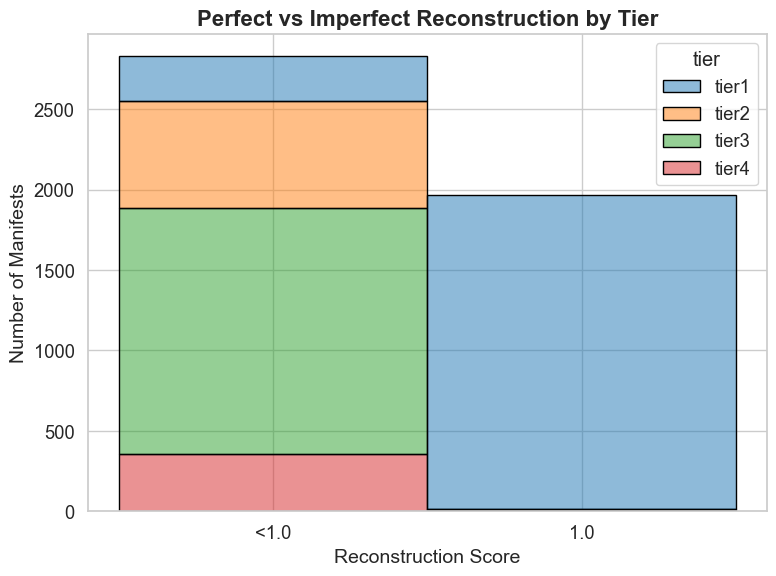

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set Seaborn style
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

# Create a new column for the two categories
report_df['score_bin'] = np.where(report_df['reconstruction_score'] == 1.0, 1.0, 0.0)

plt.figure(figsize=(8, 6))
ax = sns.histplot(
    data=report_df,
    x='score_bin',
    hue='tier',
    bins=[-0.5, 0.5, 1.5],  # two bins: [0,1)
    multiple='stack',
    palette='tab10',
    edgecolor='black',
    alpha=0.5
)
ax.set_xticks([0, 1])
ax.set_xticklabels(['<1.0', '1.0'])
ax.set_title('Perfect vs Imperfect Reconstruction by Tier', fontsize=16, weight='bold')
ax.set_xlabel('Reconstruction Score', fontsize=14)
ax.set_ylabel('Number of Manifests', fontsize=14)
plt.tight_layout()
plt.show()